In [ ]:
#default_exp measures

In [ ]:
# export 
import matplotlib.pyplot as plt
import numpy as np
from numpy.matlib import repmat
from PIL import Image
from torch import Tensor

# Implementation of non-DL particle detection techniques

## Radial symmetry algorithm

See reference. This is a conversion from Matlab script.

In [ ]:
#notest
I = np.array(Image.open('images/13.png'))/255

In [ ]:
#notest
np.savetxt("foo.csv", I, delimiter=",")

In [ ]:
#notest
nx, ny = I.shape
L = nx
assert nx == ny == L
print(nx,ny)

51 51


In [ ]:
#notest
# nx = 2n+1 so n = (nx-1) / 2 --> n = (51-1)/2 = 25
# % grid coordinates are -n:n, where Nx (or Ny) = 2*n+1
# % grid midpoint coordinates are -n+0.5:n-0.5;
# so -24.5 : 24.5 with zero in middle and length L

xm=repmat(np.arange(-(L-1)/2.0+0.5,(L)/2.0-0.5), L-1,1)
ym=repmat(np.arange(-(L-1)/2.0+0.5,(L)/2.0-0.5), L-1,1).T


In [ ]:

#notest
# Calculate derivatives along 45-degree shifted coordinates (u and v)
# Note that y increases "downward" (increasing row number) -- we'll deal
# with this when calculating "m" below.
dIdu = I[0:L-1,1:L]-I[1:L,0:L-1]
dIdv = I[0:L-1,0:L-1]-I[1:L,1:L]

print(dIdu[:5,:5])
print(dIdv[:5,:5])

[[-0.05490196 -0.01960784  0.01176471 -0.01568627 -0.01568627]
 [-0.01176471 -0.00784314  0.02745098  0.00784314 -0.00392157]
 [-0.03137255 -0.00392157  0.00784314  0.01176471 -0.01176471]
 [-0.03921569 -0.02745098  0.         -0.02352941  0.00784314]
 [-0.01960784 -0.03529412  0.00784314 -0.03137255 -0.03529412]]
[[ 0.00784314 -0.00392157  0.01176471  0.01960784  0.01568627]
 [ 0.04313725  0.05882353  0.01568627  0.02745098  0.03529412]
 [ 0.06666667  0.03137255  0.01176471  0.01568627  0.01568627]
 [ 0.03529412  0.01568627 -0.01568627  0.01176471  0.01960784]
 [ 0.01960784  0.01960784 -0.01960784  0.00784314  0.00392157]]


In [ ]:
#notest
# Smoothing -- 
from scipy.signal import convolve2d as conv2

h = np.ones((3,3))/9;  
fdu = conv2(dIdu, h, 'same')
fdv = conv2(dIdv, h, 'same')
dImag2 = fdu*fdu + fdv*fdv

print(fdu[:5,:5])
print(fdv[:5,:5])
print(dImag2[:5,:5])

[[-0.01045752 -0.00610022  0.00043573  0.00130719 -0.00305011]
 [-0.01437908 -0.00915033  0.00217865  0.00217865 -0.00392157]
 [-0.01350763 -0.00958606 -0.00087146  0.00261438 -0.00130719]
 [-0.01742919 -0.01568627 -0.01045752 -0.00740741 -0.0130719 ]
 [-0.01132898 -0.00784314 -0.00522876  0.00087146 -0.00610022]]
[[0.01176471 0.01481481 0.01437908 0.01394336 0.01525054]
 [0.02265795 0.02701525 0.02091503 0.01873638 0.01873638]
 [0.02788671 0.0291939  0.01917211 0.01525054 0.02135076]
 [0.02091503 0.01830065 0.0087146  0.00566449 0.01481481]
 [0.01742919 0.01917211 0.01699346 0.016122   0.02135076]]
[[2.47767952e-04 2.56691396e-04 2.06947945e-04 1.96125896e-04
  2.41882277e-04]
 [7.20140876e-04 8.13552242e-04 4.42185104e-04 3.55798577e-04
  3.66430765e-04]
 [9.60124548e-04 9.44176266e-04 3.68329370e-04 2.39414090e-04
  4.57563805e-04]
 [7.41215392e-04 5.80973130e-04 1.85303848e-04 8.69561090e-05
  3.90353188e-04]
 [4.32122498e-04 4.29084730e-04 3.16117732e-04 2.60678466e-04
  4.9306771

[[ 0.05882353  0.41666667  1.0625      1.20689655  0.66666667]
 [ 0.22352941  0.4939759   1.23255814  1.26315789  0.65384615]
 [ 0.34736842  0.50561798  0.91304348  1.4137931   0.88461538]
 [ 0.09090909  0.07692308 -0.09090909 -0.13333333  0.0625    ]
 [ 0.21212121  0.41935484  0.52941176  1.11428571  0.55555556]]
(50, 50)


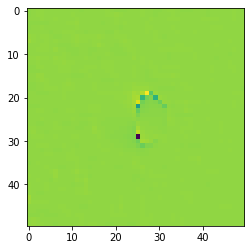

In [ ]:
#notest
# % Slope of the gradient .  Note that we need a 45 degree rotation of 
# % the u,v components to express the slope in the x-y coordinate system.
# % The negative sign "flips" the array to account for y increasing
# % "downward"

# my code to avoid divide by zero and so NaN
m = -(fdv + fdu) / (fdu - fdv)


# % *Very* rarely, m might be NaN if (fdv + fdu) and (fdv - fdu) are both
# % zero.  In this case, replace with the un-smoothed gradient.

if np.isnan(m).any():
    unsmoothm = (dIdv + dIdu) / (dIdu-dIdv)
    m[np.isnan(m)]=unsmoothm[np.isnan(m)]

# %If it's still NaN, replace with zero. (Very unlikely.)
m[np.isnan(m)]=0

plt.imshow(m)
print(m[:5,:5])
print(m.shape)

In [ ]:
#notest
# %
# % Almost as rarely, an element of m can be infinite if the smoothed u and v
# % derivatives are identical.  To avoid NaNs later, replace these with some
# % large number -- 10x the largest non-infinite slope.  The sign of the
# % infinity doesn't matter
try:
    m[np.isinf(m)]=10*max(m[~np.isinf(m)]);
except:
#     % if this fails, it's because all the elements are infinite.  Replace
#     % with the unsmoothed derivative.  There's probably a more elegant way
#     % to do this.
     m = (dIdv + dIdu) / (dIdu-dIdv);
print(m[:5,:5])

[[ 0.05882353  0.41666667  1.0625      1.20689655  0.66666667]
 [ 0.22352941  0.4939759   1.23255814  1.26315789  0.65384615]
 [ 0.34736842  0.50561798  0.91304348  1.4137931   0.88461538]
 [ 0.09090909  0.07692308 -0.09090909 -0.13333333  0.0625    ]
 [ 0.21212121  0.41935484  0.52941176  1.11428571  0.55555556]]


[[-23.05882353 -14.70833333  -0.59375      1.44827586 -10.83333333]
 [-18.02352941 -11.89156627   4.23255814   3.65789474 -10.09615385]
 [-13.98947368 -10.61797753  -1.95652174   7.89655172  -4.36538462]
 [-19.27272727 -19.69230769 -23.54545455 -24.36666667 -20.21875   ]
 [-15.3030303  -10.64516129  -8.58823529   3.45714286  -9.11111111]]


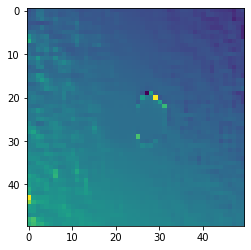

In [ ]:
#notest
#% Shorthand "b", which also happens to be the
#% y intercept of the line of slope m that goes through each grid midpoint
b = ym - m*xm
print(b[:5,:5])
plt.imshow(b)

[[7.30418935e-06 7.72433610e-06 6.35632748e-06 ... 4.74426358e-06
  5.97244676e-06 3.53107424e-06]
 [2.16830570e-05 2.50267802e-05 1.38972358e-05 ... 8.75564068e-06
  1.54663103e-05 9.05564887e-06]
 [2.95257288e-05 2.96929675e-05 1.18459786e-05 ... 1.27326230e-05
  1.75406959e-05 7.03037468e-06]
 ...
 [1.53458133e-06 1.81146963e-06 1.37735750e-05 ... 9.61756915e-06
  1.13709267e-05 4.34249428e-06]
 [7.62591352e-06 1.42740731e-05 1.79132132e-05 ... 8.09500824e-06
  1.27721383e-05 4.79980135e-06]
 [5.38477099e-06 7.90779801e-06 6.38665980e-06 ... 4.09587993e-06
  6.59846709e-06 2.64551537e-06]]


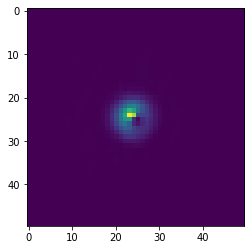

In [ ]:
#notest
#% Weighting: weight by square of gradient magnitude and inverse 
#% distance to gradient intensity centroid.
sdI2 = dImag2.sum()
xcentroid = sum(sum(dImag2*xm[:L-1,:L-1]))/sdI2;
ycentroid = sum(sum(dImag2*ym[:L-1,:L-1]))/sdI2;
w  = dImag2/np.sqrt((xm-xcentroid)*(xm-xcentroid)+(ym-ycentroid)*(ym-ycentroid))
print(w )
plt.imshow(w)

In [ ]:
# export
def lsradialcenterfit(m, b, w):
#         % least squares solution to determine the radial symmetry center
        
#         % inputs m, b, w are defined on a grid
#         % w are the weights for each point
    wm2p1 = w/(m*m+1)
    sw  = sum(sum(wm2p1))
    smmw = sum(sum(m*m*wm2p1))
    smw  = sum(sum(m*wm2p1))
    smbw = sum(sum(m*b*wm2p1))
    sbw  = sum(sum(b*wm2p1))
    det = smw*smw - smmw*sw
    xc = (smbw*sw - smw*sbw)/det    #% relative to image center
    yc = (smbw*smw - smmw*sbw)/det #% relative to image center
        
    return xc, yc
    

In [ ]:
#notest
xc, yc = lsradialcenterfit(m, b, w)
xc, yc

(0.5988018372173552, 0.8753748632077308)

In [ ]:
#notest
# Return output relative to upper left coordinate
xp = xc + (nx)/2.0;
yp = yc + (ny)/2.0;
xp,yp

(26.098801837217355, 26.375374863207732)

In [ ]:
#notest
# % A rough measure of the particle width.
# % Not at all connected to center determination, but may be useful for tracking applications; 
# % could eliminate for (very slightly) greater speed
Isub = I - min(I.flatten())
px,py = np.meshgrid(np.arange(0,nx),np.arange(0,ny));
xoffset = px - xc;
yoffset = py - yc;
r2 = xoffset*xoffset + yoffset*yoffset;
sigma = np.sqrt(sum(sum(Isub*r2))/sum(Isub.flatten()))/2 # % second moment is 2*Gaussian width
sigma

17.23081867291622

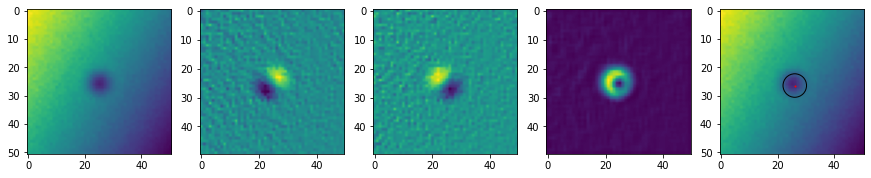

In [ ]:
#notest
fig,ax=plt.subplots(1,5,figsize=(15,3))
ax[0].imshow(I)
ax[1].imshow(dIdu)
ax[2].imshow(dIdv)
ax[3].imshow(dImag2)
ax[4].imshow(I); ax[4].scatter(x=xp,y=yp,s=1,c='r'); c1=plt.Circle((xp,yp),np.sqrt(sigma),fill=False); ax[4].add_artist(c1)

Function to calculate the center of a 2D intensity distribution.

Method: Considers lines passing through each half-pixel point with slope
parallel to the gradient of the intensity at that point.  Considers the
distance of closest approach between these lines and the coordinate
origin, and determines (analytically) the origin that minimizes the
weighted sum of these distances-squared.

In [ ]:
# export
np.seterr(divide='ignore', invalid='ignore')

def radialcenter(I):
    """
    Calculates the center of a 2D intensity distribution.
    I: image data as torch tensor or 2d numpy array
    
    """
    if type(I) is Tensor:
        I=I.numpy().squeeze()
    else:
        pass
        # assume numpy

    nx, ny = I.shape
    L=nx
    xm=repmat(np.arange(-(L-1)/2.0+0.5,(L)/2.0-0.5), L-1,1)
    ym=repmat(np.arange(-(L-1)/2.0+0.5,(L)/2.0-0.5), L-1,1).T

    
    # Calculate derivatives along 45-degree shifted coordinates (u and v)
    # Note that y increases "downward" (increasing row number) -- we'll deal
    # with this when calculating "m" below.
    dIdu = I[0:L-1,1:L]-I[1:L,0:L-1]
    dIdv = I[0:L-1,0:L-1]-I[1:L,1:L]
    
    # Smoothing -- 
    from scipy.signal import convolve2d as conv2

    h = np.ones((3,3))/9;  
    fdu = conv2(dIdu, h, 'same')
    fdv = conv2(dIdv, h, 'same')
    dImag2 = fdu*fdu + fdv*fdv
    
    # % Slope of the gradient .  Note that we need a 45 degree rotation of 
    # % the u,v components to express the slope in the x-y coordinate system.
    # % The negative sign "flips" the array to account for y increasing
    # % "downward"

    # my code to avoid divide by zero and so NaN
    m = -(fdv + fdu) / (fdu - fdv)

    # % *Very* rarely, m might be NaN if (fdv + fdu) and (fdv - fdu) are both
    # % zero.  In this case, replace with the un-smoothed gradient.

    if np.isnan(m).any():
        unsmoothm = (dIdv + dIdu) / (dIdu-dIdv)
        m[np.isnan(m)]=unsmoothm[np.isnan(m)]

    # %If it's still NaN, replace with zero. (Very unlikely.)
    m[np.isnan(m)]=0

 
    # % Almost as rarely, an element of m can be infinite if the smoothed u and v
    # % derivatives are identical.  To avoid NaNs later, replace these with some
    # % large number -- 10x the largest non-infinite slope.  The sign of the
    # % infinity doesn't matter
    try:
        m[np.isinf(m)]=10*max(m[~np.isinf(m)]);
    except:
    #     % if this fails, it's because all the elements are infinite.  Replace
    #     % with the unsmoothed derivative.  There's probably a more elegant way
    #     % to do this.
         m = (dIdv + dIdu) / (dIdu-dIdv);
    
    #% Shorthand "b", which also happens to be the
    #% y intercept of the line of slope m that goes through each grid midpoint
    b = ym - m*xm
    
    #% Weighting: weight by square of gradient magnitude and inverse 
    #% distance to gradient intensity centroid.
    sdI2 = dImag2.sum()
    xcentroid = sum(sum(dImag2*xm))/sdI2;
    ycentroid = sum(sum(dImag2*ym))/sdI2;
    w  = dImag2/np.sqrt((xm-xcentroid)*(xm-xcentroid)+(ym-ycentroid)*(ym-ycentroid))
    
    xc, yc = lsradialcenterfit(m, b, w)
    r = np.sqrt(xc**2 + yc**2)
    
    xr = xc + (L)/2.0;
    yr = yc + (L)/2.0;
    
    # % A rough measure of the particle width.
    # % Not at all connected to center determination, but may be useful for tracking applications; 
    # % could eliminate for (very slightly) greater speed
    Isub = I - min(I.flatten())
    px,py = np.meshgrid(np.arange(0,nx),np.arange(0,ny));
    xoffset = px - xc;
    yoffset = py - yc;
    r2 = xoffset*xoffset + yoffset*yoffset;
    sigma = np.sqrt(sum(sum(Isub*r2))/sum(Isub.flatten()))/2 # % second moment is 2*Gaussian width
    
    
    return(xr,yr,r,sigma,xc,yc)
    

In [ ]:
#notest
v = [16, 5, 9, 4, 2 ,11, 7 ,14];
v[2:7]

[9, 4, 2, 11, 7]

(0.5988018372173552,
 0.8753748632077308,
 26.098801837217355,
 26.375374863207732)

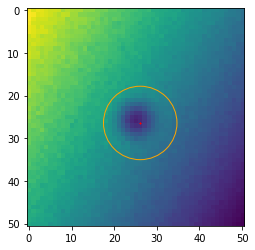

In [ ]:
#notest
I = np.array(Image.open('images/13.png'))/255
xc ,yc, r, sigma, xr, yr = radialcenter(I)
plt.imshow(I); plt.gca().scatter(x=xr,y=yr,s=1,c='r',marker='x'); c1=plt.Circle((xr,yr),sigma/2,fill=False,color='orange'); plt.gca().add_artist(c1)
xc,yc,xr,yr

In [ ]:
# hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_GenerateSyntheticImages.ipynb.
Converted 01_models.ipynb.
Converted 02_Video.ipynb.
Converted 03_Measures.ipynb.
Converted 04_fastai_adpater.ipynb.
Converted 98_Display.ipynb.
Converted 99_cli.ipynb.
Converted E1_Track1.ipynb.
Converted E1a_Track.ipynb.
Converted E2_Track1fromN.ipynb.
Converted E3_multipleparticles.ipynb.
Converted index.ipynb.
